In [4]:
import pandas as pd

# std lib
from getpass import getpass

# 3rd party
import numpy as np
import pylab as plt
from matplotlib.patches import Ellipse, Rectangle
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

from dotenv import load_dotenv
import os
load_dotenv()
import copy

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from reproject import reproject_interp

import time

# Init the DATA LAB Account

In [3]:
# token = ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))
token = ac.login(os.getenv('DATALAB_LOGIN'), os.getenv('DATALAB_PASSWORD'))
token

'helgy716.1927.1927.$1$.eZwLhFD$oX5qjpInYsoQowagYSQdc1'

# Load Known Lenses list

In [3]:
df_known = pd.read_csv('data/known_gls.csv')
df_known

,RA,DEC,Name,z_qso,z_lens,separation,N_images,W1,W2,smss
0,2.834350,-8.764300,J0011-0845,1.7,-,1.89,2,15.190,14.455,False
1,3.348077,51.318300,J0013+5119,2.63,-,2.92,2,14.677,13.920,True
2,7.093690,6.531700,PSJ0028+0631,1.06,-,2.81,2,14.160,13.363,False
3,7.563600,-15.417700,PSJ0030-1525,3.36,measured,1.78,4,14.312,13.761,False
4,11.946594,25.241100,J0047+2514,1.20,-,1.73,2,14.942,14.269,True
...,...,...,...,...,...,...,...,...,...,...
215,353.080500,-18.868500,PSJ2332-1852,1.49,-,1.97,2,14.744,13.787,False
216,355.799750,-0.842860,ULASJ2343-0050,0.787,0.3,1.32,2,14.647,13.686,False
217,356.070600,-30.940560,WISE2344-3056,1.298,1.30,2.18,4,14.758,13.889,False
218,357.491900,-45.314700,DESJ2349-4518,2.89,-,2.11,2,14.939,14.322,False


In [10]:
qc.mydb_import('gls_known', df_known[['Name', 'RA', 'DEC', 'separation', 'N_images', 'smss']])

'OK'

In [13]:
query =\
"""
select *
from mydb://gls_known
limit 10000
"""
res = qc.query(token,sql=query,format='csv')
df_gls = convert(res)
df_gls

,name,ra,dec,separation,n_images,smss
0,J0011-0845,2.834350,-8.764300,1.89,2,False
1,J0013+5119,3.348077,51.318300,2.92,2,True
2,PSJ0028+0631,7.093690,6.531700,2.81,2,False
3,PSJ0030-1525,7.563600,-15.417700,1.78,4,False
4,J0047+2514,11.946594,25.241100,1.73,2,True
...,...,...,...,...,...,...
215,PSJ2332-1852,353.080500,-18.868500,1.97,2,False
216,ULASJ2343-0050,355.799750,-0.842860,1.32,2,False
217,WISE2344-3056,356.070600,-30.940560,2.18,4,False
218,DESJ2349-4518,357.491900,-45.314700,2.11,2,False


In [9]:
match_radius = 6/3600 # 5 arcsec
match_radius

0.0016666666666666668

# Old Matching with Catalogs

## WISE 

In [ ]:
query = \
f'''SELECT  o.name, 
w.ra as ra_wise, w.dec as dec_wise,
w.source_id, 
w.w1mpro, w.w2mpro, w.w1mpro-w.w2mpro as w12mpro,
w.w1mag, w.w2mag, w.w1mag-w.w2mag as w12mag,
(q3c_dist(o.ra, o.dec, w.ra, w.dec)*3600.0) as dist_arcsec_wise
FROM mydb://objects_known AS o, 
    catwise2020.main AS w 
WHERE q3c_join(o.ra, o.dec, w.ra, w.dec, {match_radius:.6f})'''
df_wise = convert(qc.query(sql=query))
df_wise

,name,ra_wise,dec_wise,source_id,w1mpro,w2mpro,w12mpro,w1mag,w2mag,w12mag,dist_arcsec_wise
0,J0011-0845,2.834444,-8.764333,0030m091_b0-002407,15.276,14.416,0.860000,15.158,14.388,0.770000,0.355285
1,J0013+5119,3.348010,51.317792,0023p514_b0-041531,15.823,15.086,0.737000,14.504,13.955,0.549000,1.835702
2,J0013+5119,3.348089,51.318441,0023p514_b0-012624,14.861,14.191,0.670000,14.474,13.894,0.580000,0.507204
3,J0013+5119,3.350552,51.317683,0023p514_b0-055231,17.177,16.705,0.472000,14.865,14.234,0.631000,5.994552
4,PSJ0028+0631,7.093717,6.531656,0075p060_b0-001328,14.293,13.551,0.742001,14.133,13.462,0.671000,0.185638
...,...,...,...,...,...,...,...,...,...,...,...
348,WISE2344-3056,356.069619,-30.939446,3565m303_b0-030607,17.443,16.770,0.673000,14.888,14.250,0.638000,5.026571
349,DESJ2349-4518,357.492175,-45.314628,3578m455_b0-001984,14.844,14.386,0.458000,14.654,14.182,0.472000,0.743245
350,J2350+3654,357.531466,36.909498,3581p363_b0-004800,14.439,13.971,0.468000,14.217,13.772,0.445000,0.333676
351,J2350+3654,357.531103,36.910793,3581p363_b0-010181,16.232,15.744,0.488000,14.272,13.865,0.407001,4.443060


## SkyMapper

In [27]:
query =\
f'''SELECT  
    o.name, s.object_id,
    s.raj2000 as ra_smss, s.dej2000 as dec_smss, 
    s.g_psf, s.e_g_psf, s.g_petro, s.e_g_petro, 
    s.r_psf, s.e_r_psf, s.r_petro, s.e_r_petro,
    s.i_psf, s.e_i_psf, s.i_petro, s.e_i_petro,
    s.class_star, s.mean_fwhm,
    (q3c_dist(o.ra, o.dec, s.raj2000, s.dej2000)*3600.0) as dist_arcsec_smss
FROM mydb://gls_known AS o, 
    skymapper_dr4.master AS s
WHERE q3c_join(o.ra, o.dec, s.raj2000, s.dej2000, {match_radius:.6f})'''
df_smss = convert(qc.query(sql=query))
df_smss

,name,object_id,ra_smss,dec_smss,g_psf,e_g_psf,g_petro,e_g_petro,r_psf,e_r_psf,r_petro,e_r_petro,i_psf,e_i_psf,i_petro,e_i_petro,class_star,mean_fwhm,dist_arcsec_smss
0,J0011-0845,12888835,2.834493,-8.764321,20.0818,0.0583,20.0550,0.0685,19.8391,0.0764,19.8071,0.0857,19.4088,0.1479,19.4213,0.1473,0.895,7.460,0.514375
1,PSJ0028+0631,2032260711,7.093689,6.531741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.2109,0.1836,17.9215,0.0764,0.037,9.500,0.147643
2,PSJ0030-1525,12127408,7.563737,-15.417800,18.9567,0.0508,18.8935,0.0338,18.4228,NaN,18.2990,NaN,18.0451,0.0610,17.8045,0.0490,0.971,6.768,0.596367
3,HE0047-1756,2021439769,12.615981,-17.669980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.491,4.120,2.525504
4,HE0047-1756,12096346,12.615934,-17.669285,16.6355,0.0183,16.6279,0.0298,16.5217,0.0212,16.4799,0.0291,16.0170,0.0367,16.0165,0.0293,0.983,6.114,0.462804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,WISE2329-1258,7878830,352.492153,-12.981908,17.0227,0.0130,16.8673,0.0670,16.7194,0.0113,16.6210,0.0607,16.5269,0.0139,16.4826,0.0557,0.992,8.209,5.793002
105,PSJ2332-1852,6644610,353.080482,-18.868609,19.3984,0.0470,19.2339,0.0464,19.0579,0.0594,18.8524,0.0566,18.5711,0.0651,18.3519,0.0849,0.665,8.194,0.397162
106,ULASJ2343-0050,8692571,355.799878,-0.842853,19.7563,0.0143,19.6717,0.0422,19.5914,0.0217,19.5878,0.0384,19.2223,0.0493,19.1923,0.0712,0.898,6.339,0.461439
107,WISE2344-3056,3057832,356.070558,-30.940479,20.0411,0.0280,20.0326,0.0558,19.5742,0.0151,19.5343,0.0431,19.1536,0.0405,19.1874,0.0442,0.952,6.825,0.319137


## Gaia

In [ ]:
query = \
f'''
SELECT  o.name, 
    g.source_id, g.designation, 
    g.ra as ra_gaia, g.dec as dec_gaia,
    g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag,
    g.bp_rp, g.bp_g, g.g_rp, g.pseudocolour, g.pseudocolour_error,
    g.pm, g.pmra, g.pmdec, g.parallax,
    g.classprob_dsc_combmod_galaxy, g.classprob_dsc_combmod_quasar, g.classprob_dsc_combmod_star,
    (q3c_dist(o.ra, o.dec, g.ra, g.dec)*3600.0) as dist_arcsec_gaia
FROM mydb://gls_known AS o, 
    gaia_dr3.gaia_source AS g 
WHERE q3c_join(o.ra, o.dec, g.ra, g.dec, {match_radius:.6f})'''
df_gaia = convert(qc.query(sql=query))
df_gaia

,name,source_id,designation,ra_gaia,dec_gaia,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,...,pseudocolour,pseudocolour_error,pm,pmra,pmdec,parallax,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar,classprob_dsc_combmod_star,dist_arcsec_gaia
0,J0011-0845,2429242023833003648,Gaia DR3 2429242023833003648,2.834612,-8.764536,20.411530,19.861464,19.210278,0.651186,-0.550066,...,1.170234,0.184365,0.264295,-0.257158,-0.061005,0.782287,0.644160,0.329885,0.025955,1.261682
1,J0011-0845,2429242023835943040,Gaia DR3 2429242023835943040,2.834356,-8.764076,20.435870,20.418327,19.301289,1.117039,-0.017542,...,1.444565,0.166904,1.182737,0.355825,1.127944,1.160664,0.033728,0.846326,0.119947,0.807708
2,J0013+5119,395754921063313024,Gaia DR3 395754921063313024,3.348106,51.317952,20.796280,20.456110,18.911915,1.544195,-0.340170,...,1.333116,0.237867,1.692387,1.419704,-0.921204,-2.347253,0.006336,0.000188,0.993476,1.254044
3,J0013+5119,395754916769802240,Gaia DR3 395754916769802240,3.348080,51.318294,21.436610,19.942509,18.633205,1.309303,-1.494101,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000342,0.000108,0.999493,0.023110
4,J0013+5119,395754921063313152,Gaia DR3 395754921063313152,3.348419,51.318741,20.528296,20.540413,19.129456,1.410957,0.012117,...,1.617956,0.123995,0.206138,-0.023794,-0.204760,0.368197,0.000111,0.000012,0.999877,1.763172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,WISE2344-3056,2327271773580015744,Gaia DR3 2327271773580015744,356.070814,-30.940654,20.884113,20.126396,19.025782,1.100615,-0.757717,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001436,0.001080,0.997244,0.741309
406,DESJ2349-4518,6530763069403531008,Gaia DR3 6530763069403531008,357.491623,-45.314596,20.940018,20.276445,19.097870,1.178576,-0.663572,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000370,0.009245,0.989865,0.794648
407,DESJ2349-4518,6530763065108738176,Gaia DR3 6530763065108738176,357.492440,-45.314707,18.598347,18.851616,18.158554,0.693062,0.253269,...,NaN,NaN,0.240537,0.234408,0.053954,-0.147156,0.000000,1.000000,0.000000,1.368274
408,J2350+3654,2879701835971226240,Gaia DR3 2879701835971226240,357.531704,36.909022,21.051172,20.953995,19.986263,0.967731,-0.097178,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000064,0.000978,0.998728,2.176730


## Merge

In [35]:
df_merged = pd.merge(df_gls, df_wise, on='name', how='left')
df_merged = pd.merge(df_merged, df_smss, on='name', how='left')
df_merged = pd.merge(df_merged, df_gaia, on='name', how='left')
df_merged

,name,ra,dec,separation,n_images,smss,ra_wise,dec_wise,source_id_x,w1mpro,...,pseudocolour,pseudocolour_error,pm,pmra,pmdec,parallax,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar,classprob_dsc_combmod_star,dist_arcsec_gaia
0,J0011-0845,2.834350,-8.764300,1.89,2,False,2.834444,-8.764333,0030m091_b0-002407,15.276,...,1.170234,0.184365,0.264295,-0.257158,-0.061005,0.782287,0.644160,0.329885,0.025955,1.261682
1,J0011-0845,2.834350,-8.764300,1.89,2,False,2.834444,-8.764333,0030m091_b0-002407,15.276,...,1.444565,0.166904,1.182737,0.355825,1.127944,1.160664,0.033728,0.846326,0.119947,0.807708
2,J0013+5119,3.348077,51.318300,2.92,2,True,3.348010,51.317792,0023p514_b0-041531,15.823,...,1.333116,0.237867,1.692387,1.419704,-0.921204,-2.347253,0.006336,0.000188,0.993476,1.254044
3,J0013+5119,3.348077,51.318300,2.92,2,True,3.348010,51.317792,0023p514_b0-041531,15.823,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000342,0.000108,0.999493,0.023110
4,J0013+5119,3.348077,51.318300,2.92,2,True,3.348010,51.317792,0023p514_b0-041531,15.823,...,1.617956,0.123995,0.206138,-0.023794,-0.204760,0.368197,0.000111,0.000012,0.999877,1.763172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,J2350+3654,357.531433,36.909587,3.31,2,True,357.531466,36.909498,3581p363_b0-004800,14.439,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000219,0.000103,0.997469,0.075103
840,J2350+3654,357.531433,36.909587,3.31,2,True,357.531103,36.910793,3581p363_b0-010181,16.232,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000064,0.000978,0.998728,2.176730
841,J2350+3654,357.531433,36.909587,3.31,2,True,357.531103,36.910793,3581p363_b0-010181,16.232,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000219,0.000103,0.997469,0.075103
842,J2350+3654,357.531433,36.909587,3.31,2,True,357.533443,36.909768,3581p363_b0-020529,17.354,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000064,0.000978,0.998728,2.176730


In [57]:
df_merged.to_csv('data/merged_known.csv', index=False)

# Matching with Catalogs

# Anaylsis of WISE, SKyMapper, Gaia

In [5]:
df_merged = pd.read_csv('data/merged_known.csv')
df_merged

,name,ra,dec,separation,n_images,smss,ra_wise,dec_wise,source_id_x,w1mpro,...,pseudocolour,pseudocolour_error,pm,pmra,pmdec,parallax,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar,classprob_dsc_combmod_star,dist_arcsec_gaia
0,J0011-0845,2.834350,-8.764300,1.89,2,False,2.834444,-8.764333,0030m091_b0-002407,15.276,...,1.170234,0.184365,0.264295,-0.257158,-0.061005,0.782287,0.644160,0.329885,0.025955,1.261682
1,J0011-0845,2.834350,-8.764300,1.89,2,False,2.834444,-8.764333,0030m091_b0-002407,15.276,...,1.444565,0.166904,1.182737,0.355825,1.127944,1.160664,0.033728,0.846326,0.119947,0.807708
2,J0013+5119,3.348077,51.318300,2.92,2,True,3.348010,51.317792,0023p514_b0-041531,15.823,...,1.333116,0.237867,1.692387,1.419704,-0.921204,-2.347253,0.006336,0.000188,0.993476,1.254044
3,J0013+5119,3.348077,51.318300,2.92,2,True,3.348010,51.317792,0023p514_b0-041531,15.823,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000342,0.000108,0.999493,0.023110
4,J0013+5119,3.348077,51.318300,2.92,2,True,3.348010,51.317792,0023p514_b0-041531,15.823,...,1.617956,0.123995,0.206138,-0.023794,-0.204760,0.368197,0.000111,0.000012,0.999877,1.763172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,J2350+3654,357.531433,36.909587,3.31,2,True,357.531466,36.909498,3581p363_b0-004800,14.439,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000219,0.000103,0.997469,0.075103
840,J2350+3654,357.531433,36.909587,3.31,2,True,357.531103,36.910793,3581p363_b0-010181,16.232,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000064,0.000978,0.998728,2.176730
841,J2350+3654,357.531433,36.909587,3.31,2,True,357.531103,36.910793,3581p363_b0-010181,16.232,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000219,0.000103,0.997469,0.075103
842,J2350+3654,357.531433,36.909587,3.31,2,True,357.533443,36.909768,3581p363_b0-020529,17.354,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000064,0.000978,0.998728,2.176730


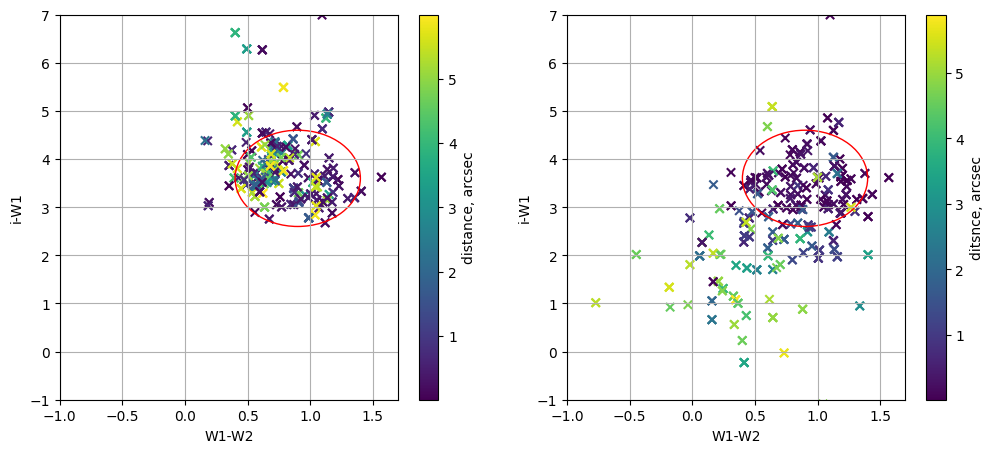

In [ ]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
col = 'i_petro'
# col = 'phot_g_mean_mag'
# plt.scatter(df_merged['w12mag'], 
#             df_merged['i_psf'] - df_merged['w1mag'],
#             # c=df_merged['dist_arcsec_y'],
#             c=df_merged['class_star'],
#             marker='.',
#            )
plt.scatter(df_merged['w12mag'], 
            df_merged[col] - df_merged['w1mag'],
            c=df_merged['dist_arcsec_wise'],
            # c=df_merged['class_star'],
            marker='x',
           )
plt.colorbar(label='distance, arcsec')
plt.grid()
plt.ylim(-1, 7)
plt.xlim(-1, 1.7)
plt.xlabel('W1-W2')
plt.ylabel('i-W1')

ax2 = plt.subplot(122)
# plt.scatter(df_merged['w12mpro'], 
#             df_merged['i_psf'] - df_merged['w1mpro'],
#             # c=df_merged['dist_arcsec_y'],
#             c=df_merged['class_star'],
#             marker='.',
#            )
cond = np.abs(df_merged['dist_arcsec_wise']-df_merged['dist_arcsec_smss']) < 1
plt.scatter(df_merged['w12mpro'], 
            df_merged[col] - df_merged['w1mpro'],
            c=np.abs(df_merged['dist_arcsec_wise']-df_merged['dist_arcsec_smss']),
            # c=df_merged['class_star'],
            marker='x',
           )
ell1 = Ellipse((0.9, 3.6), width=1.0, height=2.0, 
              edgecolor='red', facecolor='none')
ell2 = copy.copy(ell1)
ax1.add_artist(ell1)
ax2.add_artist(ell2)
plt.ylim(-1, 7)
plt.xlim(-1, 1.7)
plt.xlabel('W1-W2')
plt.ylabel('i-W1')
plt.colorbar(label='ditsnce, arcsec')
plt.grid()
plt.show()

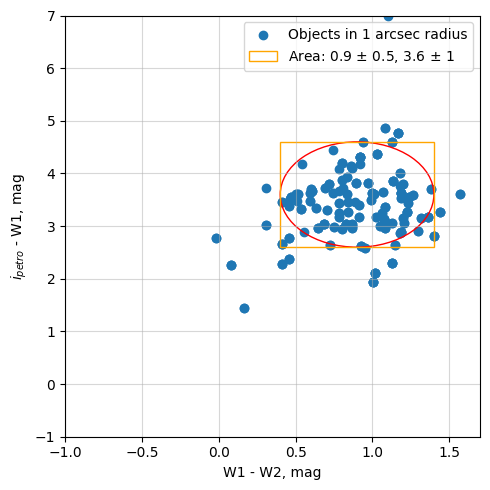

In [3]:
plt.figure(figsize=(5, 5))
ax1 = plt.subplot(111)
col = 'i_petro'

# plt.scatter(df_merged['w12mpro'], 
#             df_merged[col] - df_merged['w1mpro'],
#             # c=np.abs(df_merged['dist_arcsec_wise']-df_merged['dist_arcsec_smss']),
#             # c=df_merged['class_star'],
#             marker='x', color='gray', label='Objects in 6 arcsec radius'
#            )

cond = np.abs(df_merged['dist_arcsec_wise']-df_merged['dist_arcsec_smss']) < 1
plt.scatter(df_merged.loc[cond, 'w12mpro'], 
            df_merged.loc[cond, col] - df_merged.loc[cond, 'w1mpro'],
            # c=np.abs(df_merged.loc[cond, 'dist_arcsec_wise']-df_merged.loc[cond, 'dist_arcsec_smss']),
            # c=df_merged.loc[cond, 'class_star'],
            
            # color='black',
            marker='o', label='Objects in 1 arcsec radius'
           )

ell = Ellipse((0.9, 3.6), width=1.0, height=2.0, 
              edgecolor='red', facecolor='none', 
            #   label='0.9 +/- 0.5, 3.6 +/- 1'
              )
rec = Rectangle((0.9-0.5, 3.6-1), 1.0, 2.0,
                edgecolor='orange', facecolor='none', 
                label=r'Area: 0.9 $\pm$ 0.5, 3.6 $\pm$ 1')
ax1.add_artist(ell)
ax1.add_artist(rec)

plt.ylim(-1, 7)
plt.xlim(-1, 1.7)
plt.xlabel('W1 - W2, mag')
plt.ylabel(r'$i_{petro}$ - W1, mag')
# plt.colorbar(label='ditsnce, arcsec')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('figs/wise_smss_known.png',
            facecolor='white')
plt.show()

## Plot known GLS images

In [50]:
def get_target_wcs(ra, dec):
    # Note: If the WCS is already in ICRS, this step is not necessary.
    target_wcs = WCS(naxis=2)
    target_wcs.wcs.cd = [[-0.5/3600, 0], [0, 0.5/3600]]
    target_wcs.wcs.crpix = [10, 10]  # Reference pixel
    # target_wcs.wcs.cd = w.wcs.cd  # Pixel scale
    target_wcs.wcs.crval = [ra, dec]  # Central coordinates (RA=0, DEC=0 in ICRS)
    target_wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]  # ICRS tangent projection

    return target_wcs

def transform_fits_image(hdul, ra, dec):
    header = hdul[0].header
    data = hdul[0].data
    w = WCS(header)

    target_wcs = get_target_wcs(ra, dec)
    # print(data.shape)
    # print(target_wcs)

    # Reproject the image to the target WCS
    reprojected_data, footprint = reproject_interp((data, w), target_wcs, shape_out=(20, 20))

    # Create a new FITS HDU
    # hdu = fits.PrimaryHDU(reprojected_data, header=target_wcs.to_header())

    return reprojected_data, target_wcs

In [42]:
gr = df_merged.groupby('name')

In [52]:
image_limit = match_radius
for i, (name, frame) in enumerate(gr):
    # print(name)
    ra, dec = frame['ra'].values[0], frame['dec'].values[0]
    name = frame['name'].values[0]
    # print(ra, dec, name)

    # print(df_merged.loc[cond, 'smss'])
    if frame['smss'].any():
        continue
        
    try:
        hdul = fits.open(f'data/known/fits/{name}_i.fits')
    except:
        print(f'File {name}_i.fits did not found')
        continue

    data, w = transform_fits_image(hdul, ra, dec)
    
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(projection=w)
    ax.imshow(data, origin='lower', cmap='gray')

    # plt.scatter(frame['ra'], frame['dec'], label='Known', 
    #             transform=ax.get_transform('world'),
    #             )
    plt.scatter(frame['ra_wise'], frame['dec_wise'],  marker='x', label='WISE', 
                transform=ax.get_transform('world'),
                )
    plt.scatter(frame['ra_smss'], frame['dec_smss'],  marker='x', label='SkyMapper', 
                transform=ax.get_transform('world'),
                )
    plt.scatter(frame['ra_gaia'], frame['dec_gaia'],  marker='x', label='Gaia', 
                transform=ax.get_transform('world'), color=plt.cm.tab10(9),
                )

    plt.grid(alpha=0.2)
    plt.legend()
    plt.xlim(-0.5, 19.5)
    plt.ylim(-0.5, 19.5)
    plt.title(f"{name} sep:{frame.iloc[0]['separation']:.2f}")
    ax.coords[0].set_axislabel('RA')
    ax.coords[1].set_axislabel('DEC')
    plt.tight_layout()
    plt.savefig(f'figs/known_comp/{name}.png', facecolor='w')
    plt.close()
    plt.show()

    # if i>2:
    #     break

File B0850+054_i.fits did not found
File B1359+154_i.fits did not found
File J1004+1229_i.fits did not found
File J1616+1415_i.fits did not found
File PSJ1640+1045_i.fits did not found
File SDSSJ0832+0404_i.fits did not found
File SDSSJ0904+1512_i.fits did not found
File SDSSJ1620+1203_i.fits did not found


# Selection

In [ ]:
w = 2  # width of the strip in degrees
radius_gaia = 3.0 / 3600
radius_wise = 2.0 / 3600

for ra_mid in range(0 * w + w // 2, 360, w):
    print(f'Processing {ra_mid-w/2} to {ra_mid+w/2}...')
    query = f"""
    SELECT
        -- SkyMapper Columns
        s.object_id as source_id_smss,
        s.raj2000 as ra_smss, s.dej2000 as dec_smss,
        s.glon, s.glat,
        s.g_psf, s.e_g_psf, s.g_petro, s.e_g_petro, 
        s.r_psf, s.e_r_psf, s.r_petro, s.e_r_petro,
        s.i_psf, s.e_i_psf, s.i_petro, s.e_i_petro,
        s.class_star, s.mean_fwhm,
        
        -- Gaia Columns
        g.source_id as source_id_gaia,
        ((s.raj2000 - g.ra) * (s.raj2000 - g.ra) + (s.dej2000 - g.dec) * (s.dej2000 - g.dec)) as dist_gaia2,
        g.ra as ra_gaia, g.dec as dec_gaia,
        g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag,
        g.bp_rp, g.bp_g, g.g_rp, g.pseudocolour, g.pseudocolour_error,
        g.pm, g.pmra, g.pmdec, g.parallax,
        g.classprob_dsc_combmod_galaxy, g.classprob_dsc_combmod_quasar, g.classprob_dsc_combmod_star,
        
        -- WISE Columns
        w.source_id as source_id_wise,
        ((s.raj2000 - w.ra) * (s.raj2000 - w.ra) + (s.dej2000 - w.dec) * (s.dej2000 - w.dec)) as dist_wise2,
        w.ra as ra_wise, w.dec as dec_wise,
        w.w1mpro, w.w2mpro, w.w1mpro-w.w2mpro as w12mpro,
        w.w1mag, w.w2mag, w.w1mag-w.w2mag as w12mag

    FROM skymapper_dr4.master AS s

        -- Lateral Join with Gaia Sources
        LEFT JOIN LATERAL (
            SELECT gg.* 
            FROM gaia_dr3.gaia_source AS gg
            WHERE q3c_join(s.raj2000, s.dej2000, gg.ra, gg.dec, {radius_gaia})
            AND NOT (( (gg.pmra * gg.pmra) + (gg.pmdec * gg.pmdec) ) >= 
               9 * ( (gg.pmra_error * gg.pmra_error) + (gg.pmdec_error * gg.pmdec_error) )
                     AND gg.pm != 'nan')
            -- LIMIT 5
        ) AS g ON TRUE

        -- Changed to INNER JOIN LATERAL for WISE Sources
        INNER JOIN LATERAL (
            SELECT cw.*
            FROM catwise2020.main AS cw
            WHERE 
                q3c_join(s.raj2000, s.dej2000, cw.ra, cw.dec, {radius_wise})
                AND (cw.w1mpro - cw.w2mpro) BETWEEN 0.4 AND 1.5
                AND (s.i_petro - cw.w1mpro) BETWEEN 2.6 AND 4.6
            -- LIMIT 1 -- Adjust as needed
        ) AS w ON TRUE

    WHERE 
        s.i_petro BETWEEN 17 AND 20
        -- ra range
        AND s.raj2000 BETWEEN {ra_mid - w / 2} AND {ra_mid + w / 2}

        AND ABS(s.glat) > 15
        -- Ensure at least two Gaia sources are associated
        AND 
        (
            SELECT COUNT(*)
            FROM gaia_dr3.gaia_source AS gg
            WHERE q3c_join(s.raj2000, s.dej2000, gg.ra, gg.dec, {radius_gaia})
            AND NOT (( (gg.pmra * gg.pmra) + (gg.pmdec * gg.pmdec) ) >= 
                     9 * ( (gg.pmra_error * gg.pmra_error) + (gg.pmdec_error * gg.pmdec_error) )
                     AND gg.pm != 'nan')
        ) >= 2
        -- Exclude Major and Minor Magellanic Cloud Areas
        AND NOT (
            -- Exclude Large Magellanic Cloud (LMC) Area
            q3c_join(s.raj2000, s.dej2000, 80.894, -69.756, 6.0)
            OR
            -- Exclude Small Magellanic Cloud (SMC) Area
            q3c_join(s.raj2000, s.dej2000, 13.158, -72.822, 3.5)
        )
    LIMIT 1000;
    """
    df = qc.query(sql=query, fmt='pandas', timeout=1200)
    df.to_csv(f'./data/candidates/lists/candidates_{int(ra_mid-w/2):03d}-{int(ra_mid+w/2):03d}_2.csv', index=False)
    print(f'Processed {ra_mid-w/2} to {ra_mid+w/2}, {len(df)} candidates found. Time: {time.ctime()}')
    break


Processing 0.0 to 2.0...
Processed 0.0 to 2.0, 82 candidates found. Time: Tue Dec  3 14:34:44 2024


In [17]:
df

,source_id_smss,ra_smss,dec_smss,glon,glat,g_psf,e_g_psf,g_petro,e_g_petro,r_psf,...,source_id_wise,dist_wise2,ra_wise,dec_wise,w1mpro,w2mpro,w12mpro,w1mag,w2mag,w12mag
0,8842999,1.651023,-43.148778,329.60300,-71.5822,18.4842,0.1024,18.2780,0.0228,17.7612,...,0020m425_b0-001301,1.078389e-07,1.651062,-43.148452,14.376,13.955,0.421000,13.912,13.541,0.370999
1,8842999,1.651023,-43.148778,329.60300,-71.5822,18.4842,0.1024,18.2780,0.0228,17.7612,...,0020m425_b0-001301,1.078389e-07,1.651062,-43.148452,14.376,13.955,0.421000,13.912,13.541,0.370999
2,9001946,1.755532,-38.093284,340.51599,-75.6110,18.7910,0.0378,18.6677,0.0188,18.3617,...,0018m379_b0-001390,3.630500e-09,1.755486,-38.093244,14.503,13.792,0.711000,14.425,13.779,0.646000
3,9001946,1.755532,-38.093284,340.51599,-75.6110,18.7910,0.0378,18.6677,0.0188,18.3617,...,0018m379_b0-001390,3.630500e-09,1.755486,-38.093244,14.503,13.792,0.711000,14.425,13.779,0.646000
4,9012538,1.374004,-37.510225,343.04999,-75.8107,19.6311,0.0407,19.4175,0.0282,18.9758,...,0018m379_b0-001920,8.372020e-09,1.374055,-37.510149,14.809,14.359,0.450000,14.605,14.198,0.407000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2721882844,0.191161,-49.300137,323.32800,-65.7731,NaN,NaN,NaN,NaN,NaN,...,0000m500_b0-014057,1.099730e-09,0.191187,-49.300157,16.771,16.120,0.650999,16.737,15.871,0.865999
74,503894344,1.654212,-48.348202,322.28400,-67.0613,19.3608,0.1620,19.2375,0.0398,18.5601,...,0022m485_b0-003017,5.003645e-08,1.654319,-48.348399,15.058,14.582,0.476000,14.587,14.241,0.346000
75,503894344,1.654212,-48.348202,322.28400,-67.0613,19.3608,0.1620,19.2375,0.0398,18.5601,...,0022m485_b0-003017,5.003645e-08,1.654319,-48.348399,15.058,14.582,0.476000,14.587,14.241,0.346000
76,503895264,1.199378,-48.099681,323.26801,-67.1454,19.6897,0.0172,19.7127,0.0520,19.0712,...,0022m485_b0-001517,4.096900e-10,1.199366,-48.099665,14.589,13.705,0.884000,14.564,13.725,0.839000


In [ ]:
gr = df.groupby('source_id_smss')
for i, (name, frame) in enumerate(gr):
    print(name)
    print(frame[['ra_smss', 'dec_smss', 'ra_gaia', 'dec_gaia', 'pm', 'parallax']])

8842999
    ra_smss   dec_smss   ra_gaia   dec_gaia  pm  parallax
0  1.651023 -43.148778  1.650934 -43.149454 NaN       NaN
1  1.651023 -43.148778  1.651055 -43.148577 NaN       NaN


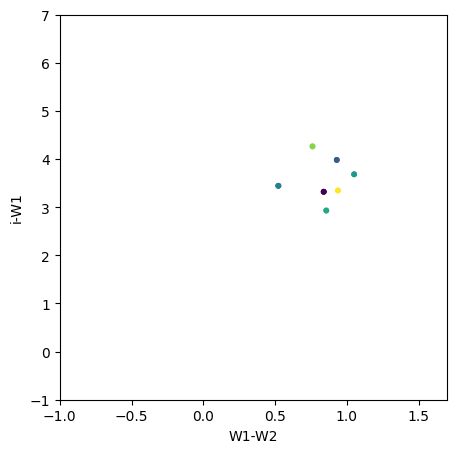

In [22]:
plt.figure(figsize=(5, 5))
plt.scatter(
    df['w1mpro']-df['w2mpro'], 
    df['i_petro']-df['w1mpro'], 
    s=10, c=df['g_psf'], cmap='viridis')
plt.ylim(-1, 7)
plt.xlim(-1, 1.7)
plt.xlabel('W1-W2')
plt.ylabel('i-W1')
plt.show()

In [23]:
# ва = pd.read_csv('data/candidates/candidates_000-000.csv')
gr = df.groupby('source_id_smss')
print(len(gr))

8


1.068573 -26.475366
33.803450 -79.459423
19.1818 19.9968 15.834


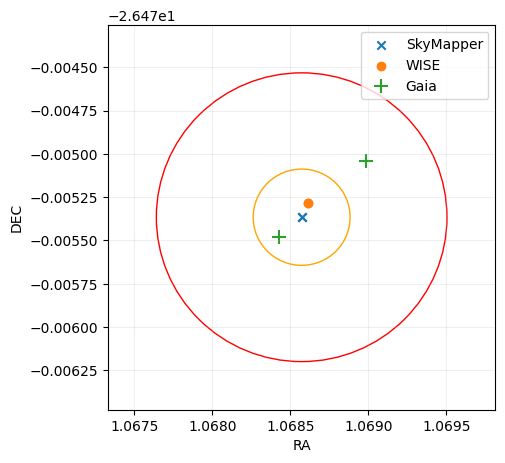

1.333985 -18.405084
69.946357 -76.265129
19.585 19.7624 15.321


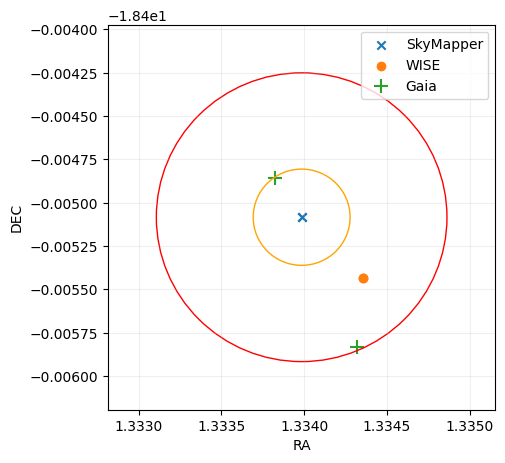

0.960456 -13.327338
81.711072 -72.273710
19.4523 19.4886 16.521


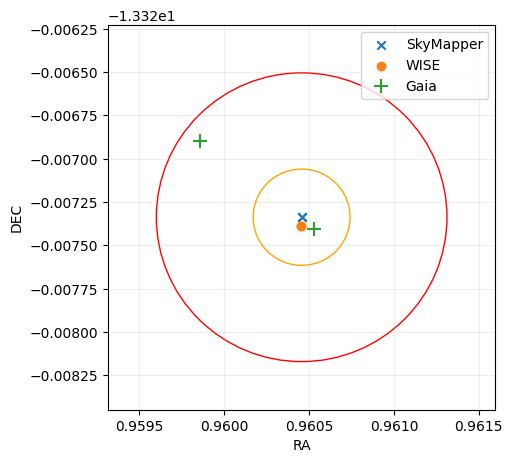

0.712918 -66.180738
310.564024 -50.221401
18.3926 19.0759 14.41


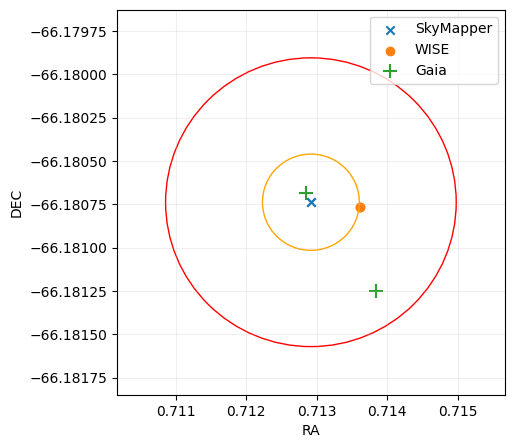

1.901908 -78.565551
305.685233 -38.327377
18.9861 19.4016 15.302


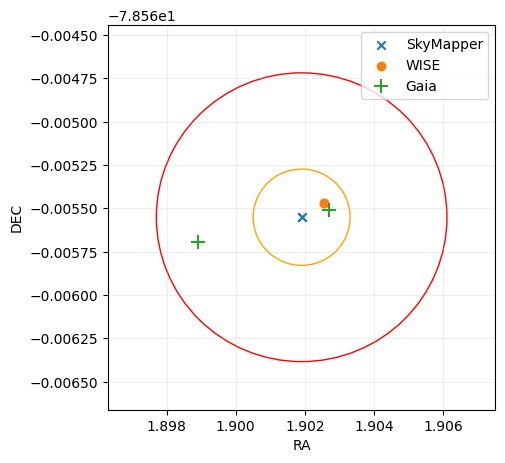

1.203894 -75.354403
306.837750 -41.418352
18.5333 18.7111 15.212


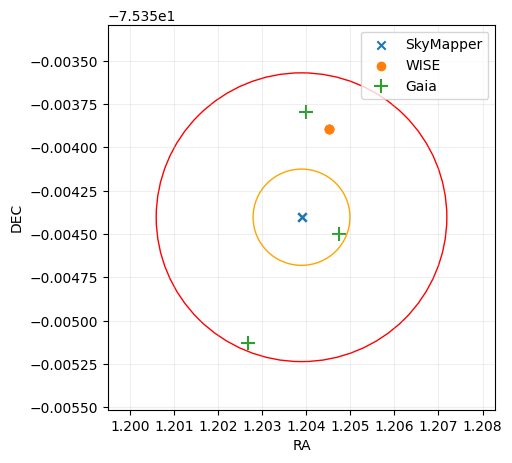

0.655477 -46.657653
325.959056 -68.227751
17.9414 19.2645 14.496


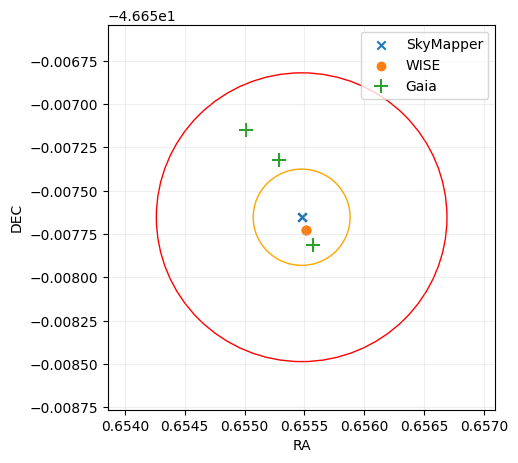

0.388425 -77.781143
306.304347 -39.018593
18.7829 nan 15.572


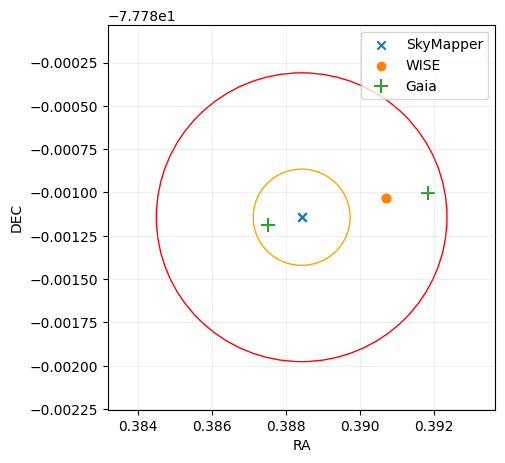

In [27]:
beg = 0
end = beg + 20
for i, (source_id, frame) in enumerate(gr):

    if i<beg:
        continue
    coord_icrs = SkyCoord(ra=frame['ra_smss'].values[0]*u.degree, dec=frame['dec_smss'].values[0]*u.degree, frame='icrs')
    print(f'{coord_icrs.ra.deg:.6f} {coord_icrs.dec.deg:.6f}')
    coord_galactic = coord_icrs.transform_to('galactic')
    print(f'{coord_galactic.l.deg:.6f} {coord_galactic.b.deg:.6f}')
    print(frame['i_petro'].values[0], frame['g_psf'].values[0], frame['w1mpro'].values[0])
    
    plt.figure(figsize=(5, 5))
    plt.scatter(frame['ra_smss'], frame['dec_smss'], label='SkyMapper', marker='x')
    plt.scatter(frame['ra_wise'], frame['dec_wise'], label='WISE')
    plt.scatter(frame['ra_gaia'], frame['dec_gaia'], label='Gaia', marker='+', s=100)
    plt.xlabel('RA')
    plt.ylabel('DEC')
    l = 4.0
    plt.xlim(frame['ra_smss'].values[0]-l/3600/np.cos(np.deg2rad(frame['dec_smss'].values[0])), 
             frame['ra_smss'].values[0]+l/3600/np.cos(np.deg2rad(frame['dec_smss'].values[0])))
    plt.ylim(frame['dec_smss'].values[0]-l/3600, frame['dec_smss'].values[0]+l/3600)
    ell = Ellipse((frame['ra_smss'].values[0], frame['dec_smss'].values[0]), 
                  width=2*3.0/3600/np.cos(np.deg2rad(frame['dec_smss'].values[0])), height=2*3.0/3600,
                    edgecolor='red', facecolor='none')
    plt.gca().add_artist(ell)
    ell = Ellipse((frame['ra_smss'].values[0], frame['dec_smss'].values[0]),
                    width=2*1.0/3600/np.cos(np.deg2rad(frame['dec_smss'].values[0])), height=2*1.0/3600,
                        edgecolor='orange', facecolor='none')
    plt.gca().add_artist(ell)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()
    if i>=end:
        break